# 패키지

In [1]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, BatchNormalization,Activation,GlobalAveragePooling2D,ZeroPadding2D, Convolution2D,concatenate,PReLU,Reshape, Multiply
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers
from tensorflow.keras import models

import datetime
import os, sys, glob
%matplotlib inline

# plt.style.use('dark_background')

# GPU 할당하기

In [2]:
from tensorflow.compat.v1 import ConfigProto,InteractiveSession
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)
print(os.popen('nvidia-smi').read())

Wed Aug 26 14:32:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   36C    P0    55W / 300W |  11557MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   36C    P0    53W / 300W |    624MiB / 32480MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
        

# 이미지 사이즈 & 모델명 정하기

In [3]:
# df, img 불러오고 model화 시키기 전 전처리과정
img_size = 251
l = 441
model_name = "sj_vgg_variation_new_real_final"
model_weight = model_name +"_weight.h5"

# DataFrame 만들기

In [4]:
BA = "/home/centos/X-Age_Ver1"

absolute_path = BA+"/03_Modeling/00_roi_final"

path= "../00_roi_final"

file_name = np.array(["{0:03d}_05.jpg".format(i+1) for i in range(l)])

df = pd.read_excel(path+"/BA_Total.xlsx")
imgs = np.array([cv2.imread(path+"/"+file_name[i]) for i in range(l)])
df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std
df.filename = file_name
df["gender"] = (df["성별"]+1)%2


# 젠더와 나이 나누기

In [5]:
def multi_generator(df):
    gender_in = np.array(df.gender)
    img_in = []
    age = np.array(df.BA_z)
    
    for file_path in df.filename:
        img = cv2.imread(path+'/'+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
        
    img_in = np.array(img_in)
        
    
    return [gender_in,img_in],age

# process 시각화 및 손실함수

In [6]:
# process시각화 및 손실함수

def plot_it(history):
    plt.style.use('default')
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    fig = plt.gcf()
    fig.savefig("../04_model_visualization/"+model_name+".jpg")
    
from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

# train_val_set 만들기

In [7]:
new_df = df.drop([218,425])
new_df = new_df.reset_index(drop=True)


from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(new_df, test_size = 0.2, random_state = 0)

train_X,train_y = multi_generator(train_df)
val_X, val_y = multi_generator(val_df)

# 모델링

# SJ_VGG_Variation

In [8]:
import sys
sys.path.insert(0,'/home/centos/X-Age_Ver1/03_Modeling/01_model_module')

In [9]:
import CNN_model_module
model = CNN_model_module.vgg_model()

In [10]:
model.save("../03_model_result/"+model_name+".h5")

In [11]:
model.compile(optimizer='adam', loss='mae',metrics=[mae_in_months])

In [113]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_12_input (InputLayer)    [(None, 251, 251, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 251, 251, 32) 896         conv2d_12_input[0][0]            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 251, 251, 32) 128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 251, 251, 32) 1056        batch_normalization_12[0][0]     
___________________________________________________________________________________________

Train on 351 samples, validate on 88 samples
Epoch 1/1000
351/351 [==============================] - 8s 22ms/sample - loss: 4.1390 - mae_in_months: 75.8464 - val_loss: 0.8484 - val_mae_in_months: 15.5458
Epoch 2/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.8038 - mae_in_months: 14.7297 - val_loss: 2.1380 - val_mae_in_months: 39.1779
Epoch 3/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.7800 - mae_in_months: 14.2939 - val_loss: 0.8796 - val_mae_in_months: 16.1176
Epoch 4/1000
351/351 [==============================] - 2s 4ms/sample - loss: 0.7583 - mae_in_months: 13.8957 - val_loss: 0.7686 - val_mae_in_months: 14.0849
Epoch 5/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.7486 - mae_in_months: 13.7170 - val_loss: 0.9409 - val_mae_in_months: 17.2425
Epoch 6/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.6868 - mae_in_months: 12.5863 - val_loss: 1.2318 - val_mae_in_months: 22.5718
Epoch 

Epoch 53/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.1895 - mae_in_months: 3.4717 - val_loss: 0.3865 - val_mae_in_months: 7.0828
Epoch 54/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.1830 - mae_in_months: 3.3527 - val_loss: 0.4804 - val_mae_in_months: 8.8037
Epoch 55/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.1616 - mae_in_months: 2.9613 - val_loss: 0.4406 - val_mae_in_months: 8.0733
Epoch 56/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.1395 - mae_in_months: 2.5562 - val_loss: 0.5252 - val_mae_in_months: 9.6238
Epoch 57/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.1754 - mae_in_months: 3.2141 - val_loss: 0.3840 - val_mae_in_months: 7.0358
Epoch 58/1000
351/351 [==============================] - 1s 2ms/sample - loss: 0.1768 - mae_in_months: 3.2395 - val_loss: 0.5203 - val_mae_in_months: 9.5348
Epoch 59/1000
351/351 [==============================] - 1

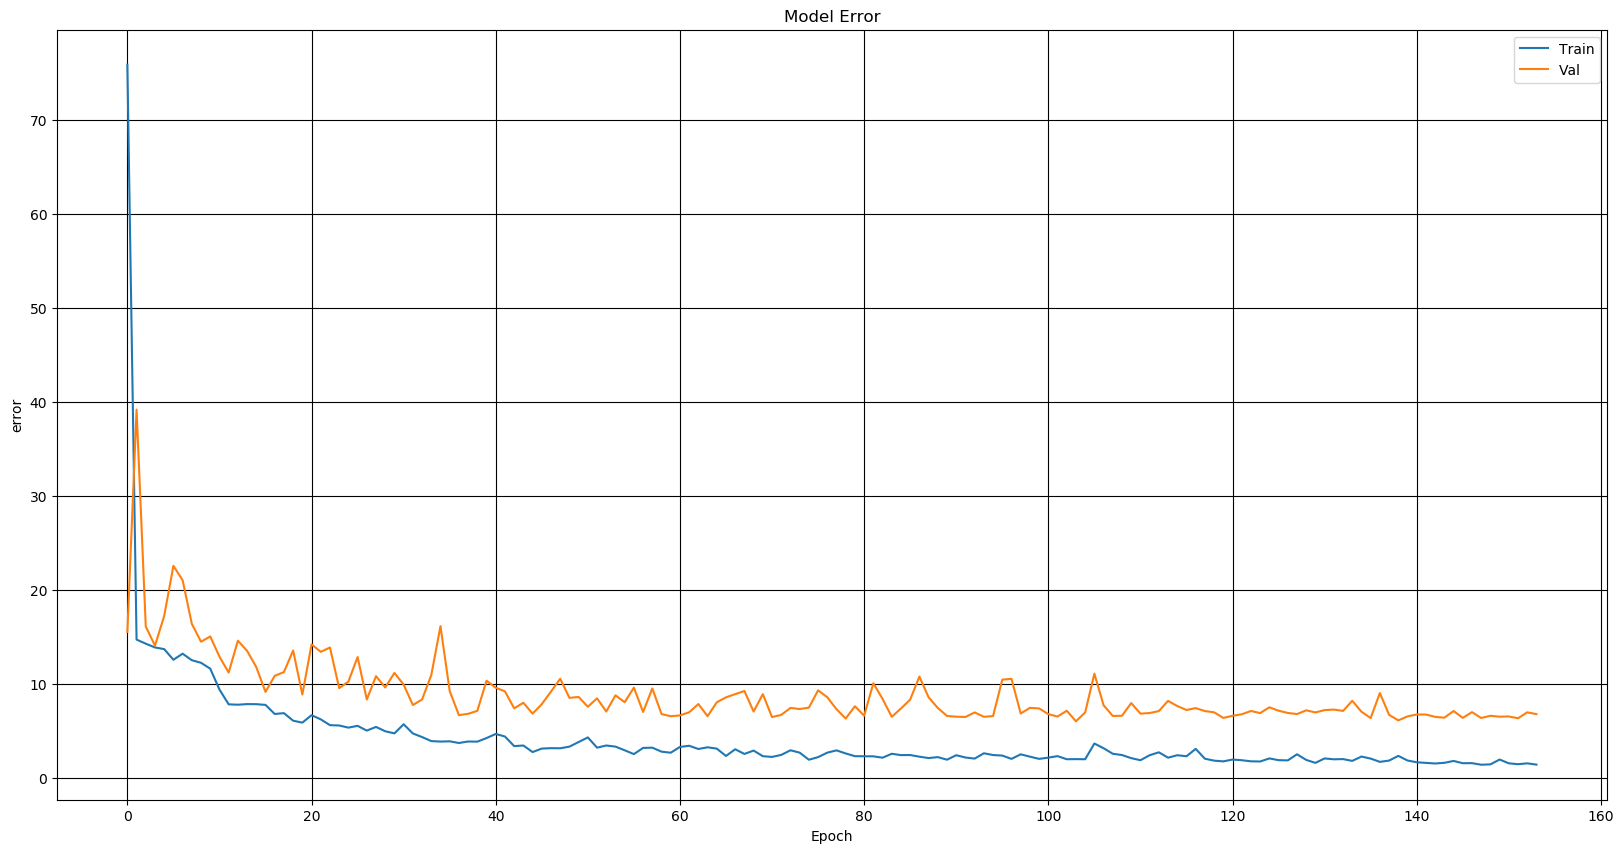

In [27]:
# 모델 fit
from tensorflow.keras.callbacks import *
epochs = 1000
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 50,
                              verbose=0, mode='auto')

mc = ModelCheckpoint("../03_model_result/"+model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=50,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,mc,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)
plot_it(history)

In [21]:
model.load_weights("../03_model_result/"+'sj_vgg_variation_new_real_weight.h5')

In [22]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
r2 = r2_score(val_df.boneage,pred)
print(f"mae_year : {mae/12}, rmse : {mse/12},  r2_score : {r2}")

88/88 [==============================] - 0s 745us/sample - loss: 0.2559 - mae_in_months: 4.6885
mae_year : 0.3907047112782796, rmse : 0.02132123245885878,  r2_score : 0.8960103443531153


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
v = val_y*ba_std+ba_mean
mean_absolute_error(v,np.round(pred))/12, mean_squared_error(v,pred)/12

(0.39071969696969694, 3.3239890575038373)

In [15]:
r2_score(v,pred)

0.897332823019629

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
# result_df = pd.DataFrame(columns=['model','mae','mse','r2_score','roi','class'])
# pd.to_csv(result_df,encoding='utf-8',index=False)
result_df = pd.read_csv("../03_model_result/result.csv")
result_df.loc[len(result_df)]=(weight_name,mae/12,mse/12,r2,"gender,ROI(251*251)")
result_df.to_csv("../03_model_result/result.csv",index=False)
result_df

model_name       mae       mse  r2_score  \
0                         sample  0.000000  0.000000  1.000000   
1                          djnet  0.439692  0.011235  0.882849   
2     sj_vgg_variation_weight.h5  0.439880  0.024005  0.865127   
3                          tjnet  0.444760  0.010932  0.886008   
4                          tjnet  0.428131  0.011775  0.877219   
5  sj_vgg_variation_weight_final  0.390705  0.021321  0.896010   

                           input  
0  gender,ROI(img_size*img_size)  
1            gender,ROI(251*251)  
2            gender,ROI(251*251)  
3            gender,ROI(251*251)  
4            gender,ROI(251*251)  
5            gender,ROI(251*251)

In [33]:
result_df = pd.read_csv("../03_model_result/result.csv")

# csv 행 삭제

In [30]:
# result_df = result_df.iloc[:-1,:]

In [34]:
result_df

model_name       mae       mse  r2_score  \
0                         sample  0.000000  0.000000  1.000000   
1                          djnet  0.439692  0.011235  0.882849   
2     sj_vgg_variation_weight.h5  0.439880  0.024005  0.865127   
3                          tjnet  0.444760  0.010932  0.886008   
4                          tjnet  0.428131  0.011775  0.877219   
5  sj_vgg_variation_weight_final  0.390705  0.021321  0.896010   

                           input  
0  gender,ROI(img_size*img_size)  
1            gender,ROI(251*251)  
2            gender,ROI(251*251)  
3            gender,ROI(251*251)  
4            gender,ROI(251*251)  
5            gender,ROI(251*251)

# 히트맵

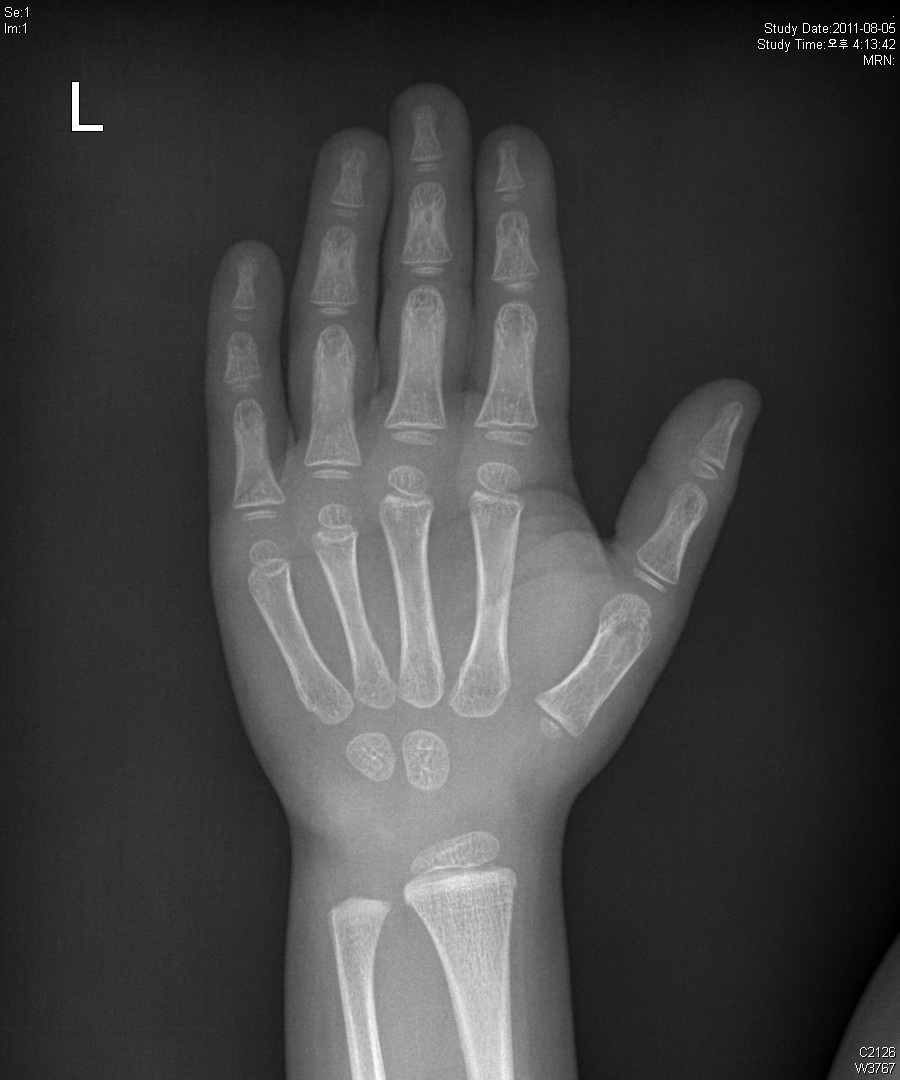

In [44]:
img

In [41]:
from tensorflow.keras.preprocessing import image

# 중간층의 모든 활성화에 있는 채널 시각화

- 몇 군데가 나오지 않아서 맨 마지막 갈수록 안보여짐
- 만약에 다 보고 싶다면 껍데기 모델에다가 적용하면 됨

#### input은 img_로 [성별,이미지]

In [114]:
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img(absolute_path+"/"+file_name[0], target_size=(251,251))
img_tensor = image.img_to_array(img)
img_tensor_4d = np.expand_dims(img_tensor, axis=0)
img_tensor_4d /= 255.
input_gender = np.array([0])
img_ = [input_gender,img_tensor_4d]

#### 모델 8층까지만 가져오기

In [115]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs=layer_outputs[:8])
activations = activation_model.predict(img_)

#### 16열로 각 층 가져오기

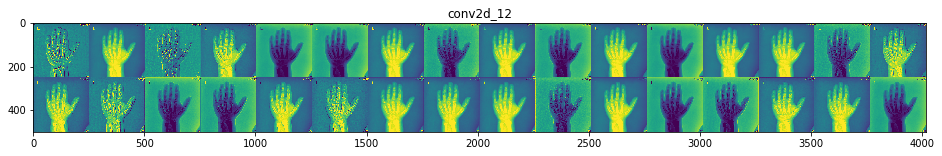

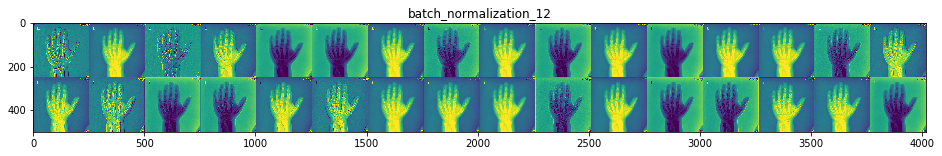

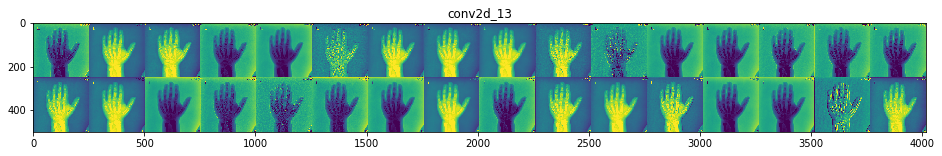

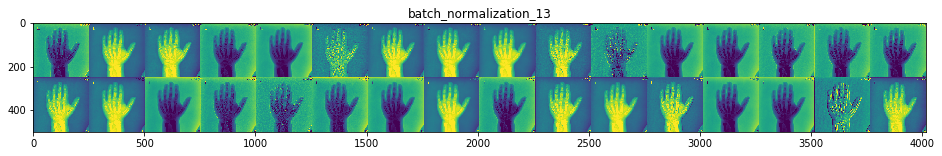

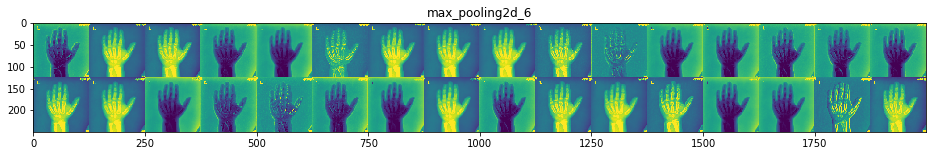

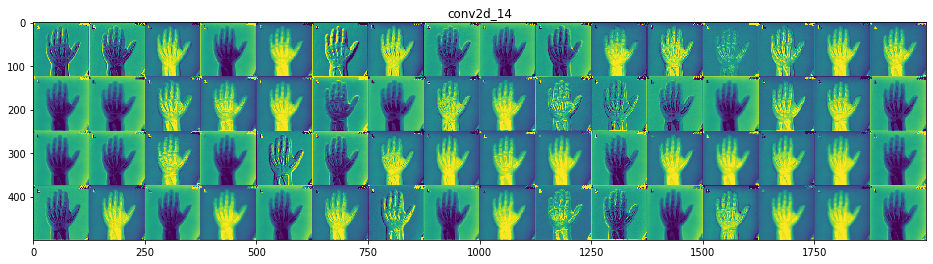

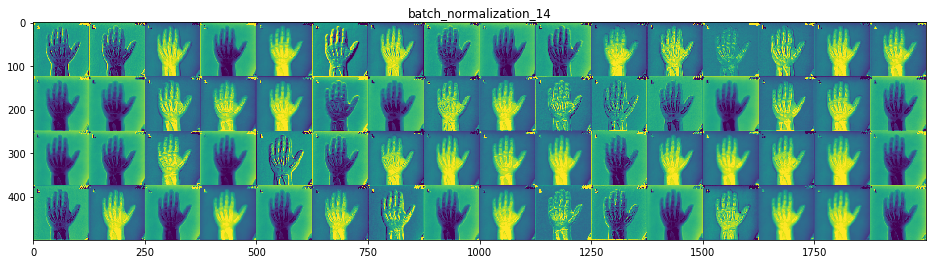

In [116]:
layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name)
images_per_row =16

for layer_name, layer_activation in zip(layer_names[1:], activations[1:]):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row*size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row+1) *size] =channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap= 'viridis')

# 모델 껍데기로 중간층 활성화

In [117]:
model_ = load_model("../03_model_result/view_gp.h5")

In [118]:
layer_outputs = [layer.output for layer in model_.layers[:8]]
activation_model = models.Model(inputs = model_.input, outputs=layer_outputs[:8])
activations = activation_model.predict(img_)

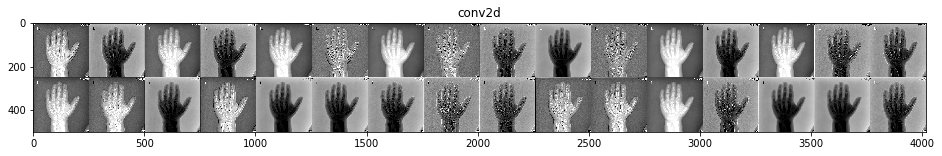

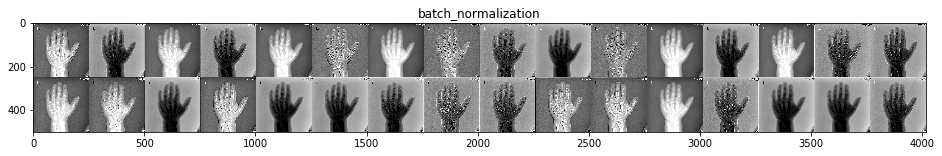

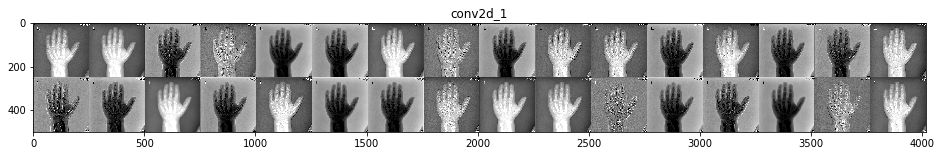

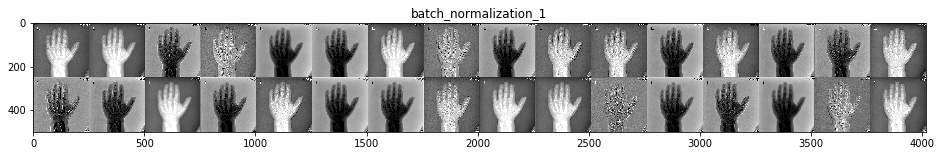

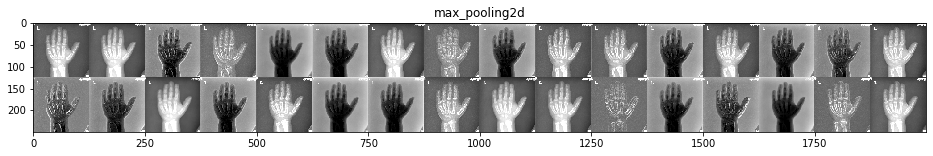

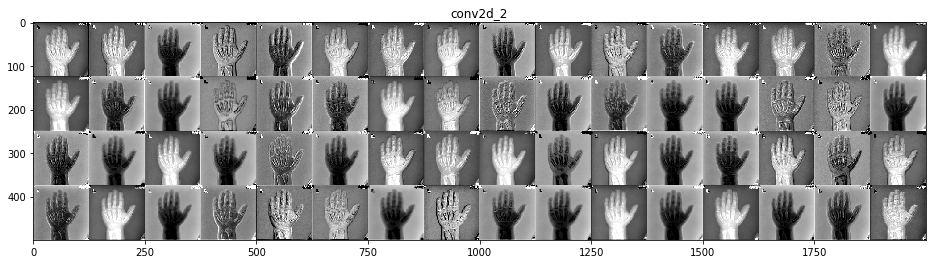

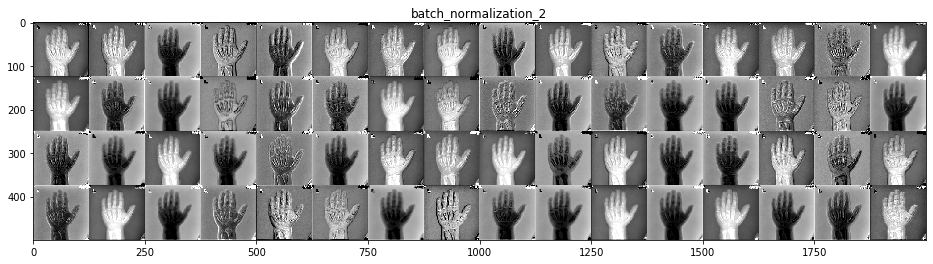

In [148]:
layer_names = []
for layer in model_.layers[:]:
    layer_names.append(layer.name)
images_per_row =16

for layer_name, layer_activation in zip(layer_names[1:], activations[1:]):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row*size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row+1) *size] =channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap= 'gray')

In [59]:
import tensorflow as tf

# 클래스 활성화의 히트맵 시각화

In [120]:
import tensorflow.keras.backend as K

In [121]:
img_[1].shape


(1, 251, 251, 3)

In [156]:
model = load_model("../03_model_result/view_gp.h5")

In [157]:
model.compile(optimizer='adam', loss='mae',metrics=[mae_in_months])

#### 맨 마지막 층의 gradient를 tape에 저장한 후, output과 비교해서 그 차이를 텐서 객체 heatmap으로 만들어낸다

In [161]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 251, 251, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 251, 251, 32) 896         conv2d_input[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 251, 251, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 251, 251, 32) 1056        batch_normalization[0][0]        
____________________________________________________________________________________________

In [166]:
img__ = img_.copy()
img__[0] = img_[0].reshape(-1,1)

In [167]:
model.inputs

[<tf.Tensor 'input_1_4:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'conv2d_input_4:0' shape=(None, 251, 251, 3) dtype=float32>]

In [168]:
model.outputs

[<tf.Tensor 'dense_4_4/Identity:0' shape=(None, 1) dtype=float32>]

In [174]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_11')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(img__)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

#### heatmap을 150*150 사이즈로 바꾸고 형식도 이미지 형식으로 변환하는 과정

In [175]:
heatmap = np.max(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((6, 6))
heatmap = (heatmap-heatmap.mean())/heatmap.std()
heatmap = -heatmap/abs(heatmap.min())
heatmap = (heatmap-heatmap.min())/2
heatmap = cv2.resize(heatmap,(150,150))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

#### 원본 이미지를 가져와서 거기에 30%만큼 heatmap을 원본에 씌운다

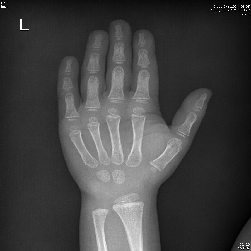

In [179]:
img = image.load_img(absolute_path+"/"+file_name[0], target_size=(251,251))

In [180]:
org = cv2.imread(absolute_path+"/"+file_name[0])
org = cv2.resize(org,(150,150))

In [181]:
final = heatmap*0.3 + org/2

#### 결과값

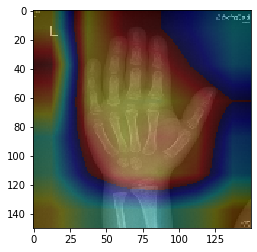

In [182]:
plt.imshow(np.uint8(final))
plt.show()